# Anchor-based 2-class word2vec classification

* p anchors per class
* k classes (k = 2)
* n features (word2vec dimensions)
* m examples

---

## Imports

In [1]:
from time import time
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.integrate import trapz

import gensim

## Load Google's Word2Vec model

In [2]:
tic = time()

# Load Google's pre-trained Word2Vec model.
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', binary=True)
print("Word2vec model loaded in %d seconds." % int(time() - tic))

Word2vec model loaded in 42 seconds.


## Get data

* Note the extreme repetition of examples in both the "lodging" and the "other" class . . . this may lead to overfitting

In [3]:
# Lodging
data_lodging = pd.read_csv("data/lodging.csv").word_clean.tolist()
data_lodging_list = [[x.strip("'") for x in words.strip("[]").split(", ")] for words in data_lodging]
flat_data_lodging_list = [item for sublist in data_lodging_list for item in sublist if item]
data_lodging_set = set(flat_data_lodging_list)

# Not Lodging
data_other = pd.read_csv("data/not_lodging.csv").word_clean.tolist()
data_other_list = [[x.strip("'") for x in words.strip("[]").split(", ")] for words in data_other]
flat_data_other_list = [item for sublist in data_other_list for item in sublist if item]
data_other_set = set(flat_data_other_list)

In [4]:
len(data_lodging_list), len(flat_data_lodging_list), len(data_lodging_set)

(67500, 90766, 8361)

In [5]:
len(data_other_list), len(flat_data_other_list), len(data_other_set)

(67500, 81580, 1659)

## Embed data in word2vec space

In [27]:
def words_to_matrix(model, word_list):
    
    word_vec_list = []
    
    for i in range(len(word_list)):
        
        try:
            word_vec = model.get_vector(word_list[i].title())
            word_vec_list.append(word_vec)
        except KeyError:
            try:
                word_vec = model.get_vector(word_list[i])
                word_vec_list.append(word_vec)
            except KeyError:
                pass
    
    word_matrix = np.array(word_vec_list).T
    
    return word_matrix
        

X_other = words_to_matrix(w2v_model, flat_data_other_list)
X_lodging = words_to_matrix(w2v_model, flat_data_lodging_list)

## Prepare X and Y matrices and shuffle

In [11]:
k = 2 # number of classes

labels_other = [0 for i in range(X_other.shape[1])]
labels_lodging = [1 for i in range(X_lodging.shape[1])]

Y_other = np.eye(k)[labels_other].T
Y_lodging = np.eye(k)[labels_lodging].T

X = np.concatenate([X_other, X_lodging], axis = 1)
Y = np.concatenate([Y_other, Y_lodging], axis = 1)

np.random.seed(1)

indices = np.array([i for i in range(X.shape[1])])
np.random.shuffle(indices)

## Split data into Train-Dev-Test sets

In [12]:
train_frac = 0.8
valid_frac = 0.1
valid_frac = 1 - train_frac - valid_frac

m = X.shape[1]
m_train = int(train_frac * m)
m_valid = int(valid_frac * m)
m_test = 1 - m_train - m_valid

ix_train = indices[:m_train] 
ix_valid = indices[m_train:m_train + m_valid]
ix_test = indices[-m_test:]

X_train = X[:, ix_train]
X_valid = X[:, ix_valid]
X_test = X[:, ix_test]

Y_train = Y[:, ix_train]
Y_valid = Y[:, ix_valid]
Y_test = Y[:, ix_test]

## Define functions

In [13]:
def random_mini_batches(X, Y, minibatch_size, seed):
    
    np.random.seed(seed)
    
    _, m = X.shape
    
    indices = np.array([i for i in range(m)])
    
    np.random.shuffle(indices)
    
    X = X[:, indices]
    Y = Y[:, indices]
    
    minibatches = []
    i = 0
    
    while i < m:
        
        minibatches.append((X[:, i:i+minibatch_size], Y[:, i:i+minibatch_size]))
        i += minibatch_size
    
    return minibatches

def create_placeholders(n, k):
    
    X = tf.placeholder(tf.float32, shape = [n, None], name = "X")
    Y = tf.placeholder(tf.float32, shape = [k, None], name = "Y")
    
    return X, Y

def initialize_A(A_words=None, model=None):

    # A.shape = (k, p, n)
    
    if A_words:
        
        p_counts = [len(A_words[label]) for label in A_words]
        assert len(set(p_counts)) == 1
        assert model != None
        
        A = np.array([[model.get_vector(w) for w in A_words[label]] for label in A_words])
        
    else:
        
        A = None
        
    return A

def initialize_tf_params(k, p, n, A_init=None, learn_A=True):
    
    # k classes
    # p anchors
    # n features
    
    if type(A_init) != np.ndarray:
        A = tf.get_variable("A", 
                            [k, p, n], 
                            dtype = tf.float32, 
                            initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    else:
        if learn_A:
            A = tf.get_variable("A", 
                                dtype = tf.float32, 
                                initializer = tf.constant(A_init, dtype = tf.float32))
        else:
            A = tf.constant(A_init, name = "A", dtype = tf.float32)
        
    w = tf.get_variable("w", [k, 1], dtype = tf.float32, initializer = tf.zeros_initializer())
    b = tf.get_variable("b", [k, 1], dtype = tf.float32, initializer = tf.zeros_initializer())
    
    params = {
        "A": A,
        "w": w,
        "b": b
    }
                        
    return params

def forward_propagate(X, params):

    # A.shape = (k, p, n)
    # X.shape = (n, m)
    # w.shape = (k, 1)
    # b.shape = (k, 1)
    
    A = params["A"]
    w = params["w"]
    b = params["b"]
    
    k = tf.shape(A)[0]
    p = tf.shape(A)[1]
    m = tf.shape(X)[1]
    
    norm_A = tf.reshape(tf.norm(A, axis = 2), (k, p, 1))
    norm_X = tf.reshape(tf.norm(X, axis = 0), (1, m))
    norm = tf.tensordot(norm_A, norm_X, [[2], [0]])
    
    prod = tf.tensordot(A, X, [[2], [0]])
    
    sim = tf.divide(prod, norm) # shape = (k, p, m)
    dist = 1 - sim
    
    D = tf.reshape(tf.reduce_prod(dist, axis = 1), (k, m)) # shape = (k, m)
    H = tf.transpose(tf.nn.softmax(tf.transpose(w * D + b))) # shape = (k, m)
    
    return H

def get_cost(Y, H, epsilon = 0.0001):
    
    # Y.shape = (k, m)
    # H.shape = (k, m)
    
    m = tf.cast(tf.shape(Y)[1], "float32")
    L = - tf.reduce_sum(Y * tf.log(tf.maximum(H, epsilon)), axis = 0)
    cost = 1/m * tf.reduce_sum(L)
    
    return cost

def get_A_reg(A, q=0, epsilon = 0.0001):
    
    # A.shape = (k, p, n)
    
    if q == 0:
        return 0
    
    k = tf.shape(A)[0]
    p = tf.shape(A)[1]
    
    norm_A = tf.reshape(tf.norm(A, axis = 2), (k, p, 1))
    norm_A_T = tf.transpose(norm_A, perm = [0, 2, 1]) # shape = (k, 1, p)
    norm = tf.tensordot(norm_A, norm_A_T, [[1, 2], [2, 1]]) # shape = (k, p, p)
    
    prod = tf.tensordot(A, tf.transpose(A, perm = [0, 2, 1]), [[1, 2], [2, 1]])
    
    sim = tf.divide(prod, norm)
    dist = tf.maximum(1 - sim, epsilon)
    
    energy = 1/2 * tf.reduce_sum(q**2 / dist)
    
    return energy

## Define anchor model

In [14]:
def model(X_train, 
          Y_train, 
          X_valid, 
          Y_valid, 
          A_init = None,
          learn_A = True,
          p = 10,
          q = 0,
          learning_rate = 0.0001,
          num_epochs = 1500, 
          minibatch_size = 32, 
          print_cost = True):
    
    # X_train.shape = (n, m)
    # Y_train.shape = (p, m)
    
    tf.reset_default_graph()
    
    tf.set_random_seed(1)
    seed = 2
    
    (n, m) = X_train.shape
    k = Y_train.shape[0]
    J_train = []
    J_valid = []
    
    X, Y = create_placeholders(n, k)
    params = initialize_tf_params(k, p, n, A_init, learn_A)
    H = forward_propagate(X, params)
    
    if learn_A:
        J = get_cost(Y, H) + get_A_reg(params["A"], q = q)
    else:
        J = get_cost(Y, H)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(J)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        tic = time()
        
        for epoch in range(num_epochs):

            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed += 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, J], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            
            if print_cost == True and epoch % 10 == 0:
                dt = time() - tic
                print ("Cost after epoch %i: %f (time elapsed = %f s)" % (epoch, epoch_cost, dt))
                
            if epoch % 1 == 0:
                J_train.append(epoch_cost)
                J_valid.append(sess.run(J, feed_dict = {X: X_test, Y: Y_test}))
        
        font = {"family": "Century Gothic", "weight": "normal", "size" : 14}
        plt.rc("font", **font)
        fig = plt.figure(figsize = (10, 7))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(np.squeeze(J_train), label = "J_train")
        ax.plot(np.squeeze(J_valid), label = "J_valid")
        ax.legend()
        ax.set_xlim([0, len(J_train)])
        ax.set_ylabel("Cost", fontdict = {"fontsize": 16, "weight": "bold"})
        ax.set_xlabel("Iteration", fontdict = {"fontsize": 16, "weight": "bold"})
        ax.set_title("%d Anchors: Charge = %g, Learning Rate = %g" % (p, q, learning_rate),
                     fontdict = {"fontsize": 24, "weight": "bold"})
        plt.show()
        
        params = sess.run(params)
        H_train = sess.run(H, feed_dict = {X: X_train})
        H_valid = sess.run(H, feed_dict = {X: X_valid})
        
        print("Training complete.")
        
        return (params, H_train, H_valid, J_train, J_valid)

## Initialize A, and Train Model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Cost after epoch 0: 0.188598 (time elapsed = 4.563668 s)
Cost after epoch 10: 0.134831 (time elapsed = 49.264306 s)
Cost after epoch 20: 0.133636 (time elapsed = 93.726831 s)
Cost after epoch 30: 0.133330 (time elapsed = 138.428899 s)


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


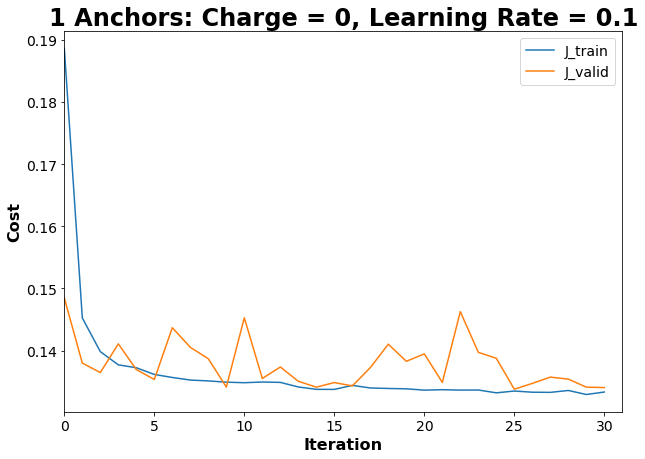

Training complete.


In [15]:
k = Y_train.shape[0]
p = 10
n = X_train.shape[0]

A_words = {
    0: ["shoe", "plant", "bird", "yellow", "the", "why", "computer", "angry", "yesterday", "bored"],
    1: ["travel", "hotel", "resort", "airfare", "cruise", "plane", "vacation", "train", "inn", "Hilton"]
}

A_init = initialize_A(A_words = A_words, model = w2v_model)

result = model(X_train, 
               Y_train, 
               X_valid, 
               Y_valid, 
               A_init = None,
               learn_A = True,
               p = 1,
               q = 0,
               learning_rate = 0.1, # 0.001
               num_epochs = 31, 
               minibatch_size = 32, 
               print_cost = True)

In [16]:
params, H_train, H_valid, J_train, J_valid = result
acc_train = sum(np.argmax(H_train, axis = 0) == np.argmax(Y_train, axis = 0))/Y_train.shape[1]
acc_valid = sum(np.argmax(H_valid, axis = 0) == np.argmax(Y_valid, axis = 0))/Y_valid.shape[1]

print("Train Accuracy: %f" % acc_train)
print("  Dev Accuracy: %f" % acc_valid)

Train Accuracy: 0.954920
  Dev Accuracy: 0.956731


## Print Learned Anchor Words

In [17]:
def get_nearest_words(A_matrix):

    k, p, n = A_matrix.shape
    A_words = {}

    for label in range(k):
        anchor_list = []
        for anchor in range(p):
            word = w2v_model.similar_by_vector(A_matrix[label, anchor, :])[0][0]
            anchor_list.append(word)
        A_words[label] = anchor_list
        
    return A_words

learned_A_words = get_nearest_words(params["A"])
learned_A_words

{0: ['VSECU'], 1: ['VSECU']}

In [22]:
w2v_model.distance("Marriott", "VSECU")

0.8833323346484783

In [188]:
params["w"]

array([[-22.276428],
       [ 17.378826]], dtype=float32)

## Define ROC Functions

In [18]:
def predict(probabilities, thresh=0.5):
    probs = probabilities
    predictions = (probs > thresh).astype(int)
    return predictions

def get_tpr_and_fpr(predictions, ground_truth, pos, neg):
    ground_truth = np.array(ground_truth)
    tpr = np.sum(np.logical_and(predictions == 1, ground_truth == 1))/pos
    fpr = np.sum(np.logical_and(predictions == 1, ground_truth == 0))/neg
    return tpr, fpr

def get_roc(probabilities, y, thresh_values):

    y = np.array(y)
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)

    roc_tpr = []
    roc_fpr = []

    for v in thresh_values:
        predictions = predict(probabilities, v)
        tpr, fpr = get_tpr_and_fpr(predictions, y, pos, neg)
        roc_tpr.append(tpr)
        roc_fpr.append(fpr)

    auc = -trapz(roc_tpr, roc_fpr)

    roc = {
        "tpr" : roc_tpr,
        "fpr" : roc_fpr,
        "auc" : auc
    }

    return roc

def plot_roc(y, probs, N=500, title=None):
  
    thresh_values = np.arange(N)/N

    assert len(probs) == len(y)

    roc = get_roc(probs, y, thresh_values)

    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(1, 1, 1, aspect = "equal")
    ax.grid(True)

    cmap = "RdYlBu"
    
    ax.scatter(roc["fpr"], 
           roc["tpr"], 
           s = 100, 
           c = thresh_values, 
           cmap = cmap,
           marker = '.', 
           edgecolors = 'none')

    ax.plot([0, 1], [0, 1], 'k-')
    norm = matplotlib.colors.Normalize(thresh_values[0], thresh_values[-1])
    sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks=np.linspace(0, 1, 11))
    cbar.set_label("Threshold Value")

    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.show()
    plt.gcf().clear()

    return roc

## Plot ROC

In [19]:
probs_train = H_train[1, :]
y_train = Y_train[1, :]

probs_valid = H_valid[1, :]
y_valid = Y_valid[1, :]

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


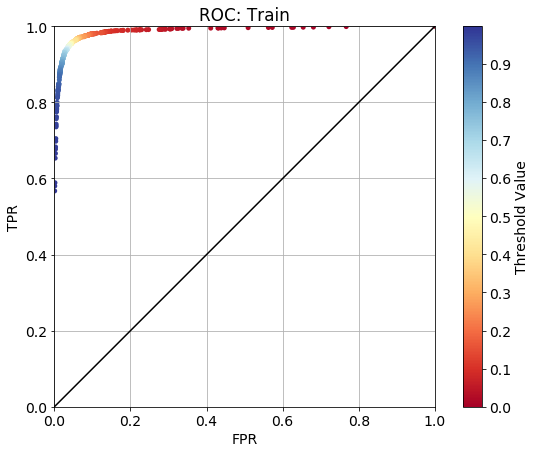

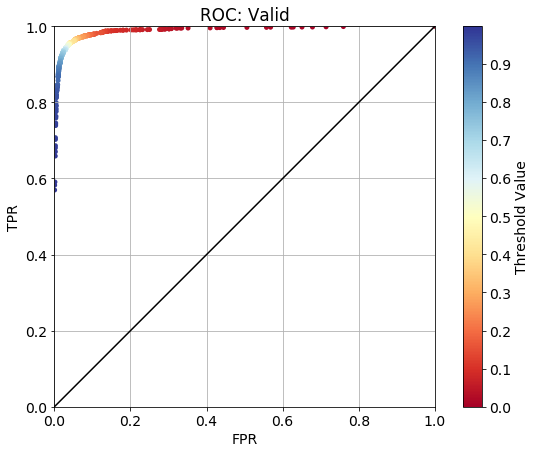

Train AUC: 0.988317
  Dev AUC: 0.989522


In [20]:
roc_train = plot_roc(y_train, probs_train, title = "ROC: Train")
roc_valid = plot_roc(y_valid, probs_valid, title = "ROC: Valid")

print("Train AUC: %f" % roc_train["auc"])
print("  Dev AUC: %f" % roc_valid["auc"])

In [192]:
w2v_model.most_similar(["Purified_Drinking_Water"])

[('Purified_Water', 0.530529260635376),
 ('Pocari_Sweat', 0.5229222178459167),
 ('Chlor', 0.5134046077728271),
 ('Pure_Drinking_Water', 0.5128960013389587),
 ('Citizen_Watches', 0.5078005194664001),
 ('Aquaguard', 0.5077773332595825),
 ('Scented_Candles', 0.5049846768379211),
 ('Laundry_Detergent', 0.49561530351638794),
 ('Organic_Skincare', 0.49197813868522644),
 ('FoodBizIntel', 0.49158114194869995)]